# Extract Information from Drivers License


* Mounting the data from the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-ocr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 53.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
import random
import string
import math
import itertools
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import pandas as pd
import keras_ocr

#### Getting Data
* Using the keras_ocr.tools.read to load the image *data*

In [ ]:
#Data paths
training_data_folder_path = '/content/drive/MyDrive/DrivingLicenseDataset/Training Data'
testing_data_folder_path = '/content/drive/MyDrive/DrivingLicenseDataset/Test Data'
validation_data_folder_path = '/content/drive/MyDrive/DrivingLicenseDataset/Validation Data'
train_ground_truth_file_path = training_data_folder_path + '/' + 'Train Data - Ground Truth .xlsx'
test_ground_truth_file_path = testing_data_folder_path + '/' + 'Test Data - Ground Truth .xlsx'

# Process Data
***
#### Loading and preprocessing the image data

###### Resizing and Denoising
* Resized the image to a standard size (800x600)
* Guassian frequency helps to reduce the high frequency noise in the image
* Morphological closing helps to remove the small noise and fill gaps in the image



In [ ]:
def load_and_preprocess_image(image_path):
    try:
        # Loading the image using keras_ocr.tools.read
        image = keras_ocr.tools.read(image_path)

        # Applying additional image preprocessing using OpenCV
        resized_image = cv2.resize(image, (800, 600))

        # Applying noise reduction using Gaussian blur
        blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        #Applying morphologyical morphing to denoise the image
        denoised_image = cv2.morphologyEx(resized_image, cv2.MORPH_CLOSE, kernel)

        return denoised_image
    except Exception as e:
        # print(f"Error loading image {image_path}: {e}")
        return None

In [ ]:
def load_and_preprocess_images(folder_path):
    images = []
    image_file_names = []

    for state_folder in os.listdir(folder_path):
        state_folder_path = os.path.join(folder_path, state_folder)
        if os.path.isdir(state_folder_path):
            for image_file in os.listdir(state_folder_path):
                if image_file.endswith(".png"):
                    # Check if the image name contains "Back" and removing back side images
                    if "Back" not in image_file:
                        image_path = os.path.join(state_folder_path, image_file)
                        preprocessed_image = load_and_preprocess_image(image_path)
                        if preprocessed_image is not None:
                            images.append(preprocessed_image)
                            image_file_names.append(image_file.replace('.png', ''))

    return images, image_file_names

In [ ]:
# Loading and preprocessing train images
train_images, train_image_file_names = load_and_preprocess_images(training_data_folder_path)
df_train_image_data = pd.DataFrame({
    'Image': train_images,
    'File Name': train_image_file_names
})
print(f'The number of train images loaded {len(train_images)}')

The number of train images loaded 147


In [ ]:
# Loading and preprocessing test images
test_images, test_image_file_names = load_and_preprocess_images(testing_data_folder_path)
df_test_image_data = pd.DataFrame({
    'Image': test_images,
    'File Name': test_image_file_names
})
print(f'The number of test images loaded {len(test_images)}')

The number of test images loaded 44


In [ ]:
# Loading and preprocessing validation images
validation_images, validation_image_file_names = load_and_preprocess_images(validation_data_folder_path)
df_validation_image_data = pd.DataFrame({
    'Image': validation_images,
    'File Name': validation_image_file_names
})
print(f'The number of validation images loaded {len(validation_images)}')

The number of validation images loaded 43


#### Loading Ground Truth
###### Cleaning and extracting the necessary columns

In [ ]:
def load_and_preprocess_ground_truth(ground_truth_file_path, relevant_columns):
    # Loading the ground truth data from Excel file
    ground_truth_data = pd.read_excel(ground_truth_file_path)

    # Selecting relevant columns
    ground_truth_data = ground_truth_data[relevant_columns].copy()

    # Filling missing values in 'Address 2' column with an empty string and concatenate with 'Address'
    ground_truth_data['Address 2'].fillna('', inplace=True)
    ground_truth_data['Address'] = ground_truth_data['Address'] + ',' + ground_truth_data['Address 2']

    # Drops the 'Address 2' column
    ground_truth_data.drop('Address 2', axis=1, inplace=True)

    return ground_truth_data


In [ ]:
# Loading Test Ground Truth
relevant_train_columns = ['File Name ', 'First Name /Given Name', 'Last Name / Surname',
                    'Date of Birth', 'Address', 'Address 2', 'City ', 'State/Province', 'Postal/ZIP Code']
ground_truth_train_data = load_and_preprocess_ground_truth(train_ground_truth_file_path, relevant_train_columns)

ground_truth_train_data['File Name'] = ground_truth_train_data['File Name '].str.strip()
ground_truth_train_data['City'] = ground_truth_train_data['City ']

df_train_image_data['File Name'] = df_train_image_data['File Name'].str.strip()
df_train_data_with_ground_truth = df_train_image_data.merge(ground_truth_train_data, on='File Name', how='left')
df_train_data_with_ground_truth.dropna(inplace=True)
print(f'The total number of training data {len(df_train_data_with_ground_truth)}')

The total number of training data 91


In [ ]:
# Loading Train Ground Truth
relevant_test_columns = ['File Name', 'First Name /Given Name', 'Last Name / Surname',
                    'Date of Birth', 'Address', 'Address 2', 'City', 'State/Province', 'Postal/ZIP Code']
ground_truth_test_data = load_and_preprocess_ground_truth(test_ground_truth_file_path, relevant_test_columns)

ground_truth_test_data['File Name'] = ground_truth_test_data['File Name'].str.strip()
df_test_image_data['File Name'] = df_test_image_data['File Name'].str.strip()
df_test_data_with_ground_truth = df_test_image_data.merge(ground_truth_test_data, on='File Name', how='left')
df_test_data_with_ground_truth.dropna(inplace=True)
print(f'The total number of test data {len(df_test_data_with_ground_truth)}')

The total number of test data 38


### Data Agumentation
* Integrates data augmentation using Keras' ImageDataGenerator. It applies transformations like rotation, shifts, shear, and zoom to images, creating extra training samples. Original images are expanded into multiple variations (num_augmented_images) and merged with the main dataset. This boosts model performance by enhancing its adaptability to various image styles during training. More about data augmentation can be found in the [Keras Documentation](https://keras.io/api/data_loading/image/)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
data_generator = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='nearest'
)

images = []
ground_truth = []
num_augmented_images = 3  # Number of augmented images to be generated from each original image

for index, row in df_train_data_with_ground_truth.iterrows():
    image = row['Image']
    image = np.array(image)  # Converting image to numpy array

    # Applying data augmentation to generate additional images
    img_generator = data_generator.flow(np.expand_dims(image, axis=0), batch_size=1)
    for i in range(num_augmented_images):
        augmented_image = img_generator.next()
        augmented_image = augmented_image[0]

        images.append(augmented_image)

        # Adding the corresponding ground truth data to the list
        ground_truth.append({
            'First Name /Given Name': row['First Name /Given Name'],
            'Last Name / Surname': row['Last Name / Surname'],
            'Date of Birth': row['Date of Birth'],
            'Address': row['Address'],
            'City': row['City'],
            'State/Province': row['State/Province'],
            'Postal/ZIP Code': row['Postal/ZIP Code']
        })

# Converting ground truth to DataFrame
df_ground_truth = pd.DataFrame(ground_truth)

# Merging image data and ground truth
df_train_data_with_ground_truth_augmented = pd.DataFrame({
    'Image': images
}).merge(df_ground_truth, left_index=True, right_index=True)

print(len(df_train_data_with_ground_truth_augmented))


273


***
# keras-ocr
#### Keras OCR is a user-friendly toolkit designed for Optical Character Recognition (OCR) tasks using the Keras library. With Keras OCR, transforming images of text into machine-readable text becomes effortless. It offers pre-processing functions to enhance image quality, supports various model architectures for customization, and simplifies the training process. Detailed documentation is here [Keras OCR GitHub repository](https://github.com/faustomorales/keras-ocr)

In [ ]:
from keras_ocr.detection import Detector
from keras_ocr.recognition import Recognizer
from keras_ocr.pipeline import Pipeline


In [ ]:
detector = Detector()
recognizer = Recognizer()
pipeline = Pipeline(detector=detector, recognizer=recognizer)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


#### Calculating the character accuracy, Word accuracy, Edit distance

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

# A function to calculate accuracy metrics
def calculate_metrics(predictions, ground_truth_text):
    predicted_text = predictions[0][0][1]  # Accessing the text from the tuple
    predicted_text = str(predicted_text)  # Convert numpy array to string

    # Calculate character accuracy
    total_characters = len(ground_truth_text)
    correct_characters = sum(c1 == c2 for c1, c2 in zip(ground_truth_text, predicted_text))
    character_accuracy = correct_characters / total_characters * 100

    # Calculate word accuracy
    ground_truth_words = ground_truth_text.split()
    predicted_words = predicted_text.split()
    total_words = len(ground_truth_words)
    correct_words = sum(w1 == w2 for w1, w2 in zip(ground_truth_words, predicted_words))
    word_accuracy = correct_words / total_words * 100

    # Calculate edit distance
    edit_distance = nltk.edit_distance(ground_truth_text, predicted_text)

    return character_accuracy, word_accuracy, edit_distance, predicted_text



#### Model is extracting the text from the images

In [ ]:
#A function to evaluate the model and store metrics
import time
def evaluate_model(df, dataset_type, print_results=True):
    character_accuracies = []
    word_accuracies = []
    edit_distances = []
    predicted_texts = []
    actual_predictions = []
    processing_times = []

    for index, row in df.iterrows():
        # Get the preprocessed image from the row
        image = row['Image']
        # Record start time
        start_time = time.time()

        # Run OCR on the current image
        predictions = pipeline.recognize([image])

        # Record end time
        end_time = time.time()

        processing_time = end_time - start_time

        processing_times.append(processing_time)



        # Extract ground truth text from the row
        if dataset_type!='Validation':
          ground_truth_text = (
              row['First Name /Given Name']
              + ' ' + row['Last Name / Surname']
              + ' ' + str(row['Date of Birth'])
              + ' ' + row['Address']
              + ' ' + row['City']
              + ' ' + row['State/Province']
              + ' ' + str(row['Postal/ZIP Code'])
          )
        else:
          ground_truth_text = None
        actual_predictions.append(predictions)

        if dataset_type!='Validation':
          # Calculate accuracy metrics and predicted text
          character_accuracy, word_accuracy, edit_distance, predicted_text = calculate_metrics(predictions, ground_truth_text)

          character_accuracies.append(character_accuracy)
          word_accuracies.append(word_accuracy)
          edit_distances.append(edit_distance)
          predicted_texts.append(predicted_text)
        if print_results:
            print(f"Ground Truth: {ground_truth_text}")
            print(f"Predicted Text: {predicted_text}")
            print(f"Character Accuracy: {character_accuracy:.2f}%")
            print(f"Word Accuracy: {word_accuracy:.2f}%")
            print(f"Edit Distance: {edit_distance}")
            print(f"Processing Time: {processing_time:.4f} seconds")
            print()

            # Plot the preprocessed image
            plt.imshow(image)
            plt.title(f"Predicted Text: {predicted_text}")
            plt.axis('off')
            plt.show()
    # Create a DataFrame to store the results
    if dataset_type!='Validation':
      results_df = pd.DataFrame({
          'Ground Truth': df['Ground Truth'] if 'Ground Truth' in df.columns else None,
          'Predicted Text': predicted_texts,
          'Character Accuracy': character_accuracies if character_accuracies else None,
          'Word Accuracy': word_accuracies if word_accuracies else None,
          'Edit Distance': edit_distances if edit_distances else None,
          'Processing Time': processing_times,
          'Predictions': actual_predictions
      })
    else:
      predicted_text = predictions[0][0][1]  # Accessing the text from the tuple
      predicted_text = str(predicted_text)  # Convert numpy array to string
      predicted_texts.append(predicted_text)

      results_df = pd.concat([
      pd.DataFrame({'Predicted Text': predicted_texts}),
      pd.DataFrame({'Processing Time': processing_times}),
      pd.DataFrame({'Predictions': actual_predictions})
  ], axis=1)



    return results_df



In [ ]:
# Evaluate the model on the training data
train_results_df = evaluate_model(df_train_data_with_ground_truth,'Training', print_results=False)

2/2 [==============================] - 0s 56ms/step


###### Performance metrics of training data

In [ ]:
train_character_accuracy_avg = train_results_df['Character Accuracy'].mean()
train_word_accuracy_avg = train_results_df['Word Accuracy'].mean()
train_edit_distance_avg = train_results_df['Edit Distance'].mean()
train_processing_time_avg = train_results_df['Processing Time'].mean()

print(f"Training Dataset Average Character Accuracy: {train_character_accuracy_avg:.2f}%")
print(f"Training Dataset Average Word Accuracy: {train_word_accuracy_avg:.2f}%")
print(f"Training Dataset Average Edit Distance: {train_edit_distance_avg:.2f}")
print(f"Training Dataset Average Processing Time: {train_processing_time_avg:.2f} seconds")


Training Dataset Average Character Accuracy: 3.39%
Training Dataset Average Word Accuracy: 0.00%
Training Dataset Average Edit Distance: 87.25
Training Dataset Average Processing Time: 1.56 seconds


In [ ]:
# Evaluate the model on the testing data
test_results_df = evaluate_model(df_test_data_with_ground_truth,'Testing', print_results=False)

###### Performance metrics of testing data

In [ ]:
test_character_accuracy_avg = test_results_df['Character Accuracy'].mean()
test_word_accuracy_avg = test_results_df['Word Accuracy'].mean()
test_edit_distance_avg = test_results_df['Edit Distance'].mean()
test_processing_time_avg = test_results_df['Processing Time'].mean()

print(f"Testing Dataset Average Character Accuracy: {test_character_accuracy_avg:.2f}%")
print(f"Testing Dataset Average Word Accuracy: {test_word_accuracy_avg:.2f}%")
print(f"Testing Dataset Average Edit Distance: {test_edit_distance_avg:.2f}")
print(f"Testing Dataset Average Processing Time: {test_processing_time_avg:.2f} seconds")

Testing Dataset Average Character Accuracy: 4.01%
Testing Dataset Average Word Accuracy: 0.00%
Testing Dataset Average Edit Distance: 79.53
Testing Dataset Average Processing Time: 0.81 seconds


In [ ]:
# Evaluate the model on the validation data
validation_results_df = evaluate_model(df_validation_image_data,'Validation', print_results=False)

###### Performance metrics of validation data

In [ ]:
validation_processing_time_avg = validation_results_df['Processing Time'].mean()
print(f"Validation Dataset Average Processing Time: {validation_processing_time_avg:.2f} seconds")

Validation Dataset Average Processing Time: 0.78 seconds


###  Visualization
* This plotting demonstrates the visualization of image quality after preprocessing and showcases the bounding box detection process using Keras OCR.

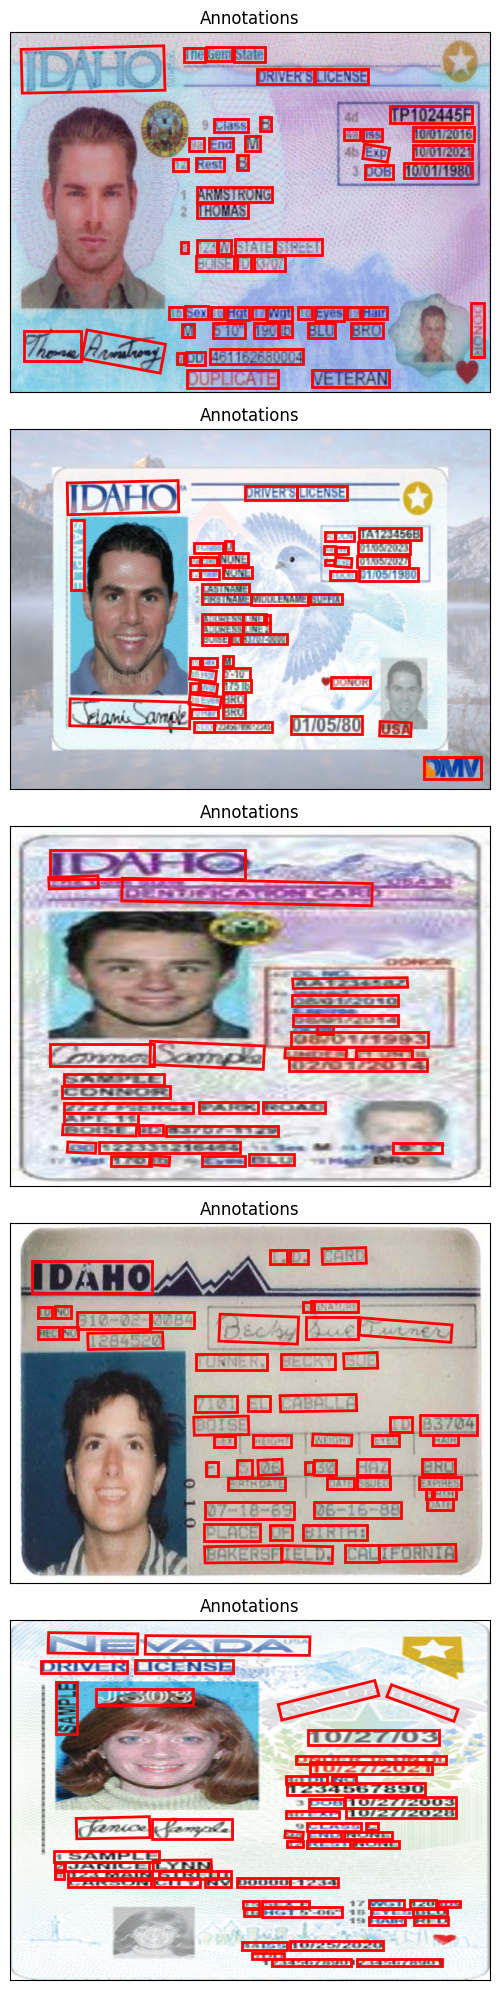

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

df_sample = df_train_data_with_ground_truth.head(5)
images = df_sample['Image']
predictions = train_results_df['Predictions']

# Create subplots and manually draw bounding boxes using Matplotlib
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, prediction_list in zip(axs, images, predictions):
    ax.imshow(image, cmap='gray')

    for character, box in prediction_list[0]:
        vertices = box.astype(int)
        rect = patches.Polygon(vertices, closed=True, edgecolor='r', linewidth=2, fill=False)
        ax.add_patch(rect)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Annotations')

plt.tight_layout()
plt.show()


## Extraction of Data
###### From the prediction data eExtracting Name, Address, DOB, City, State, Zipcode from Prediction Data using Keywords and Regex Patterns

In [ ]:
import re

# Define keywords for each field along with their text patterns
field_keywords = {
    'First Name': ['FIRST NAME', 'first name', 'GIVEN NAME', 'Given names'],
    'Last Name': ['LAST NAME', 'last name', 'surname', 'Family name'],
    'Date of Birth': ['DOB', 'date of birth', 'DATE OF BIRTH', 'Date of Birth'],
    'Address Line': ['address', 'street', 'AVENUE', 'STREET', 'APT'],
    'City': ['city', 'street'],
    'State': ['state'],
    'Zipcode': ['zipcode', 'postal code']
}

# Define regular expressions for each field
field_regex_patterns = {
    'First Name': r'(?i)(?:first\s*name|given\s*name)[:\s]*(.+)',
    'Last Name': r'(?i)(?:last\s*name|surname)[:\s]*(.+)',
    'Address Line': r'(?i)address[:\s]*(.+)',
    'City': r'(?i)city[:\s]*(.+)',
    'State': r'[A-Za-z]{2}',  # Two-letter state code
    'Zipcode': r'\d{5}'  # Example: 12345
}

def extract_fields_with_keywords_and_regex(text):
    extracted_fields = {}
    state_found = False
    address_lines = []
    for line in text.split('\n'):
        if not state_found:
            for keyword in field_keywords['State']:
                if re.search(keyword, line, re.IGNORECASE):
                    state_match = re.search(field_regex_patterns['State'], line)
                    if state_match:
                        extracted_fields['State'] = state_match.group(0)
                        state_found = True
                        break
        for field, keywords in field_keywords.items():
            if field == 'State' or field == 'Address Line':
                continue  # Skip State and Address Line fields, as they are handled separately
            for keyword in keywords:
                pattern = re.compile(rf'{keyword}[:\s]*(.+)', re.IGNORECASE)
                match = pattern.search(line)
                if match:
                    extracted_fields[field] = match.group(1).strip()
                    break
            if field not in extracted_fields:
                regex_pattern = field_regex_patterns.get(field)
                if regex_pattern:
                    match = re.search(regex_pattern, line)
                    if match and match.group(0):
                        extracted_fields[field] = match.group(0).strip()
        address_match = re.search(field_regex_patterns['Address Line'], line)
        if address_match:
            address_lines.append(address_match.group(1).strip())
    if address_lines:
        extracted_fields['Address Line'] = ', '.join(address_lines)
    return extracted_fields

def extract_date_of_birth(text):
    dob_pattern = r'\b\d{1,2}/\d{1,2}/\d{4}\b'
    dob_match = re.search(dob_pattern, text)
    if dob_match:
        return dob_match.group(0)
    return ''

def extract_fields_from_ocr_predictions(images, predictions):
    extracted_data = []

    for image, prediction_list in zip(images, predictions):
        formatted_prediction = [char for char, box in prediction_list[0]]
        extracted_text = ''.join(formatted_prediction)
        extracted_fields = extract_fields_with_keywords_and_regex(extracted_text)

        if 'State' not in extracted_fields and 'Address Line' in extracted_fields:
            address = extracted_fields['Address Line']
            state_code_match = re.search(field_regex_patterns['State'], address)
            if state_code_match:
                extracted_fields['State'] = state_code_match.group(0)

        extracted_fields['Date of Birth'] = extract_date_of_birth(extracted_text)

        extracted_data.append(extracted_fields)

    return extracted_data


##### Downloading the results

In [ ]:
import pandas as pd

def create_extracted_fields_df(images, predictions,filename):
    extracted_data = extract_fields_from_ocr_predictions(images, predictions)

    df = pd.DataFrame(extracted_data)
    df['Image File'] = filename

    # All columns are present even if some fields are missing
    columns_order = ['Image File', 'First Name', 'Last Name', 'Date of Birth', 'Address Line', 'City', 'State', 'Zipcode']
    for column in columns_order:
        if column not in df.columns:
            df[column] = ''

    df = df[columns_order]  # Reorder columns

    return df


In [ ]:
df_train = create_extracted_fields_df(df_train_data_with_ground_truth['Image'],train_results_df['Predictions'] , df_train_data_with_ground_truth['File Name'])
df_train.to_csv('train_extracted_fields.csv', index=False)

In [ ]:
df_test = create_extracted_fields_df(df_train_data_with_ground_truth['Image'], test_results_df['Predictions'], df_train_data_with_ground_truth['File Name'])
df_test.to_csv('test_extracted_fields.csv', index=False)

In [ ]:
df_valid = create_extracted_fields_df(df_validation_image_data['Image'], validation_results_df['Predictions'], df_validation_image_data['File Name'])
df_valid.to_csv('validation_extracted_fields.csv', index=False)

## Fine tuning the Recognizer of Keras OCR**

*By following the documentation of the Keras OCR tried to fine tune the model to improve the performance. But it didn't run here due to some python issue. [Reference Documentation](https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html).

*Fine-tuning recognizer with keras-ocr*

In [ ]:
!pip install imgaug
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
#defining and compiling the recognizer
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()

Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
import imgaug
import keras_ocr
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define batch size and augmenter
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

# Split the train dataset into train and validation sets
train_data, validation_data = sklearn.model_selection.train_test_split(df_train_data_with_ground_truth, test_size=0.2, random_state=42)

# Create labels for train and validation datasets
train_labels = train_data[['First Name /Given Name', 'Last Name / Surname', 'Address', 'City', 'State/Province', 'Postal/ZIP Code']]
validation_labels = validation_data[['First Name /Given Name', 'Last Name / Surname', 'Address', 'City', 'State/Province', 'Postal/ZIP Code']]

# Define recognizer and get input shape information
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()
input_height = recognizer.model.input_shape[1]
input_width = recognizer.model.input_shape[2]
input_alphabet = recognizer.alphabet

# Function to filter out labels with illegal characters
def filter_labels(labels, alphabet):
    filtered_labels = []
    for label in labels:
        if all(c in alphabet for c in label):
            filtered_labels.append(label)
    return filtered_labels

# Filter train and validation labels
train_labels_filtered = filter_labels(train_labels.astype(str).values.flatten(), input_alphabet)
validation_labels_filtered = filter_labels(validation_labels.astype(str).values.flatten(), input_alphabet)

# Load test labels
test_labels = df_test_data_with_ground_truth.drop(columns=['Image'])
test_labels = test_labels[['First Name /Given Name', 'Last Name / Surname', 'Address', 'City', 'State/Province', 'Postal/ZIP Code']]

# Load and preprocess test images
test_images = []
for image_path in df_test_data_with_ground_truth['Image']:
    try:
        image = keras_ocr.tools.read(image_path)
        resized_image = cv2.resize(image, (input_width, input_height))
        test_images.append(resized_image)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
test_images = np.array(test_images)

# Set up image generator for testing
test_image_gen, test_steps = (
    keras_ocr.datasets.get_recognizer_image_generator(
        labels=[(image, text) for image, text in zip(test_images, test_labels.values.flatten())],
        height=input_height,
        width=input_width,
        alphabet=input_alphabet,
        augmenter=None  # No augmentation for testing
    ),
    len(test_images) // batch_size
)

# # Example of accessing and displaying data from the generator
# try:
#     training_image_gen = recognizer.get_batch_generator(image_generator=training_image_gen, batch_size=batch_size)
#     image, text = next(training_image_gen)
#     print('Text:', text)
#     plt.imshow(image)
#     plt.show()
# except StopIteration:
#     print("No more batches available in the generator.")


In [ ]:
# Define callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]

# Train the recognizer
recognizer.training_model.fit(
    x=training_image_gen,  # Use the custom image generator for training data
    steps_per_epoch=training_steps,
    validation_data=validation_gen,  # Use the custom image generator for validation data
    validation_steps=validation_steps,
    callbacks=callbacks,
    epochs=1000,
)
